# 3D segmentation with [MONAI](https://github.com/Project-MONAI/MONAI) and [Catalyst](https://github.com/catalyst-team/catalyst)

This tutorial demonstrates how [MONAI](https://github.com/Project-MONAI/MONAI) can be used with the [Catalyst](https://github.com/catalyst-team/catalyst) framework for 3D segmentation task.
And easily use below features:

* Prepare synthetic data.
* Load Nifti image with metadata.
* Transforms for dictionary format data.
* Add channel dim to the data if no channel dimension.
* Scale medical image intensity with expected range.
* Crop out a batch of balanced images based on positive / negative label ratio.
* 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
* Sliding window inference method.
* Deterministic training for reproducibility.

This tutorial is based on [unet_training_dict.py](https://github.com/Project-MONAI/MONAI/blob/master/examples/segmentation_3d/unet_training_dict.py) and [spleen_segmentation_3d.ipynb](https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/spleen_segmentation_3d.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/unet_segmentation_3d_catalyst.ipynb)

## Setup environment

In [ ]:
%pip install -qU "monai[nibabel, tensorboard]"

In [ ]:
%pip install -qU matplotlib
%matplotlib inline

In [ ]:
%pip install -q catalyst==20.07

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import logging
import os
import shutil
import sys
import tempfile

import catalyst.dl
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch

from monai.config import print_config
from monai.data import Dataset, create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    AsChannelFirstd,
    Compose,
    LoadNiftid,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    ToTensord,
)
from monai.utils import first

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Setup logging

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# [MONAI](https://github.com/Project-MONAI/MONAI) components

## Prepare synthetic data

In [ ]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1, channel_dim=-1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"img{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "img*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

## Prepare transforms and datasets

In [ ]:
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:20], segs[:20])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-20:], segs[-20:])]

# define transforms for image and segmentation
train_transforms = Compose(
    [
        LoadNiftid(keys=["img", "seg"]),
        AsChannelFirstd(keys=["img", "seg"], channel_dim=-1),
        ScaleIntensityd(keys=["img", "seg"]),
        RandCropByPosNegLabeld(
            keys=["img", "seg"],
            label_key="seg",
            spatial_size=[96, 96, 96],
            pos=1,
            neg=1,
            num_samples=4,
        ),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 2]),
        ToTensord(keys=["img", "seg"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["img", "seg"]),
        AsChannelFirstd(keys=["img", "seg"], channel_dim=-1),
        ScaleIntensityd(keys=["img", "seg"]),
        ToTensord(keys=["img", "seg"]),
    ]
)

# define dataset, data loader
check_ds = Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
check_loader = torch.utils.data.DataLoader(
    check_ds, batch_size=2, num_workers=4, collate_fn=list_data_collate
)
check_data = first(check_loader)
print(check_data["img"].shape, check_data["seg"].shape)

# create a training data loader
train_ds = Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)
# create a validation data loader
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate
)

## Prepare model, optimizer and metrics

In [ ]:
# create UNet, DiceLoss and Adam optimizer
# device = torch.device("cuda:0")  # you don't need device, because Catalyst uses autoscaling
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

dice_metric = DiceMetric(include_background=True, to_onehot_y=False, sigmoid=True, reduction="mean")

# [Catalyst](https://github.com/catalyst-team/catalyst) experiment

## Setup Runner

In [ ]:
class MonaiSupervisedRunner(catalyst.dl.SupervisedRunner):
    def forward(self, batch):
        if self.is_train_loader:
            output = {self.output_key: self.model(batch[self.input_key])}
        elif self.is_valid_loader:
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            output = {
                self.output_key: sliding_window_inference(
                    batch[self.input_key], roi_size, sw_batch_size, self.model
                )
            }
        elif self.is_infer_loader:
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            batch = self._batch2device(batch, self.device)
            output = {
                self.output_key: sliding_window_inference(
                    batch[self.input_key], roi_size, sw_batch_size, self.model
                )
            }
            output = {**output, **batch}
        return output

## Run experiment

In [ ]:
log_dir = os.path.join(root_dir, "logs")
runner = MonaiSupervisedRunner(
    input_key="img", input_target_key="seg", output_key="logits"
)  # you can also specify `device` here
runner.train(
    loaders={"train": train_loader, "valid": val_loader},
    model=model,
    criterion=loss_function,
    optimizer=optimizer,
    num_epochs=6,
    logdir=log_dir,
    main_metric="dice_metric",
    minimize_metric=False,
    verbose=False,
    timeit=True,  # let's use minimal logs, but with time checkers
    callbacks={
        "loss": catalyst.dl.CriterionCallback(input_key="seg", output_key="logits"),
        "periodic_valid": catalyst.dl.PeriodicLoaderCallback(valid=2),
        "dice_metric": catalyst.dl.MetricCallback(
            prefix="dice_metric", metric_fn=dice_metric, input_key="seg", output_key="logits"
        ),
    },
    load_best_on_end=True,  # user-friendly API :)
)

# Tensorboard logs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=log_dir

# Best model performance visualisation

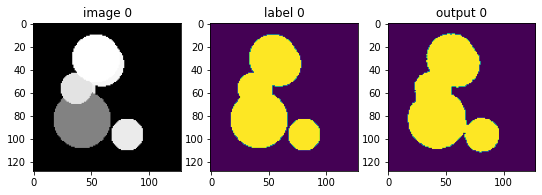

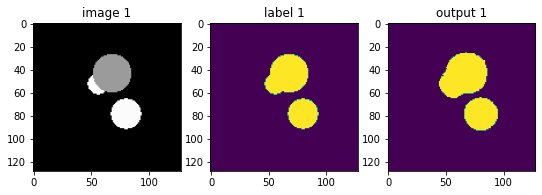

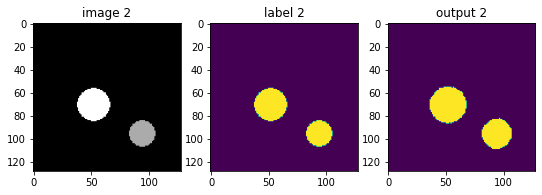

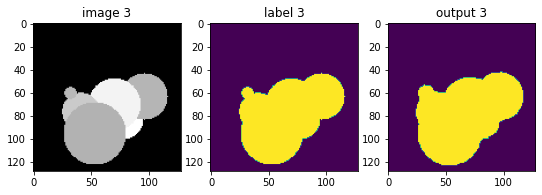

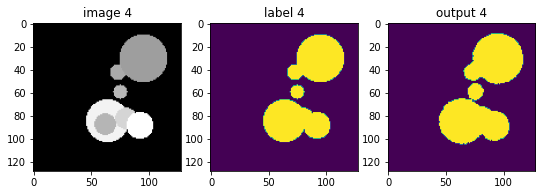

In [ ]:
for i, valid_output in enumerate(runner.predict_loader(loader=val_loader)):
    if i > 4:
        break
    plt.figure("check", (9, 3))
    plt.subplot(1, 3, 1)
    plt.title("image " + str(i))
    plt.imshow(valid_output["img"].detach().cpu()[0, 0, :, :, 48], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label " + str(i))
    plt.imshow(valid_output["seg"].detach().cpu()[0, 0, :, :, 48])
    plt.subplot(1, 3, 3)
    plt.title("output " + str(i))
    logits = valid_output["logits"]
    plt.imshow((logits[0] > 0.5).float().detach().cpu()[0, :, :, 48])
    plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)